In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels as sm
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

/Users/gokberk/miniconda3/envs/ml4hc_project2/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('data/electric_demand/energy_dataset.csv')

In [3]:
df = df[['time','total load actual']]

temp_s = pd.to_datetime(df['time'])
temp_s = temp_s.apply(lambda x: x.strftime('%Y-%m'))

df['time'] = temp_s

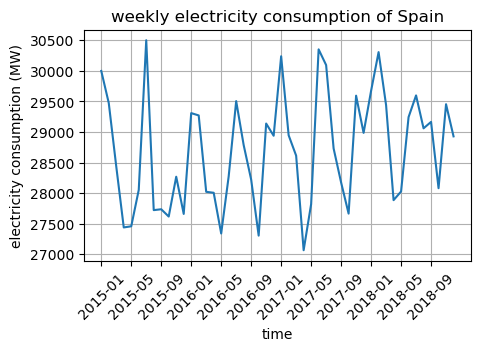

In [4]:
temp_df = df.groupby('time').agg('mean').reset_index()

plt.figure(figsize=(5,3))
plt.plot(temp_df.time, temp_df['total load actual'])
plt.xticks(np.arange(len(temp_df['time']))[::4],temp_df['time'][::4])
plt.tick_params(axis='x', labelrotation=45)
plt.xlabel('time')
plt.ylabel('electricity consumption (MW)')
plt.title('weekly electricity consumption of Spain')
plt.grid()
plt.show()

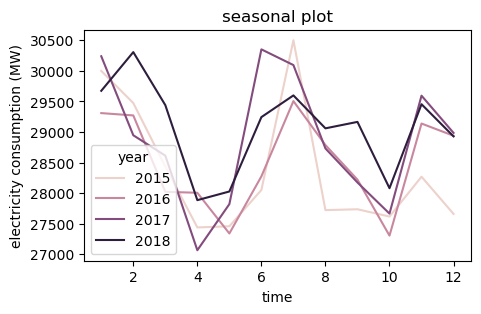

In [5]:
plt.figure(figsize=(5,3))
temp_df['month'] = temp_df['time'].apply(lambda x: pd.to_datetime(x).date().month)
temp_df['year'] = temp_df['time'].apply(lambda x: pd.to_datetime(x).date().year)
sns.lineplot(data=temp_df, x='month', y='total load actual', hue='year', legend='full')
plt.title('seasonal plot')
plt.xlabel('time')
plt.ylabel('electricity consumption (MW)')
plt.show()

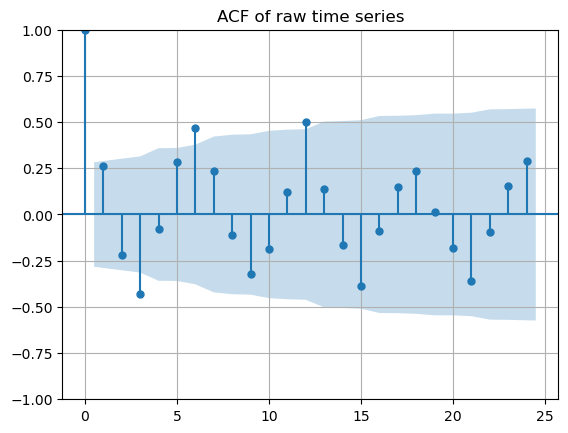

In [8]:
# acf
import statsmodels as sm
sm.graphics.tsaplots.plot_acf(temp_df['total load actual'].values, lags=24)
plt.grid()
plt.title('ACF of raw time series')
plt.show()

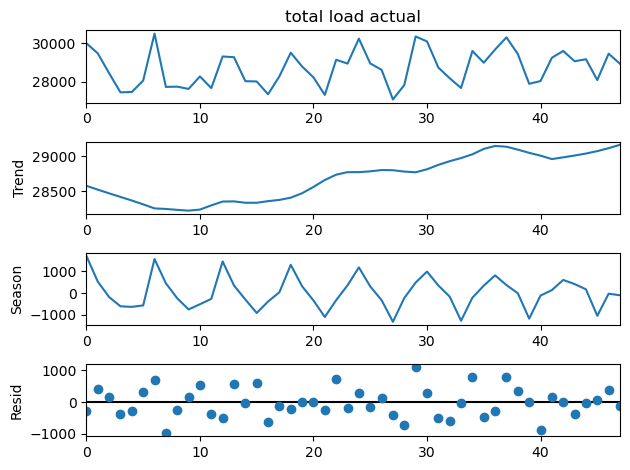

In [9]:
from statsmodels.tsa.seasonal import STL

res = STL(temp_df['total load actual'], period=6).fit()
res.plot()
plt.show()

forecasting efforts below

In [10]:
df = pd.read_csv('data/electric_demand/energy_dataset.csv')
df = df[['time','total load actual']]

In [11]:
temp_s = pd.to_datetime(df['time'])
temp_s = temp_s.apply(lambda x: x.strftime('%Y-%m-%d'))
df['time'] = temp_s

temp_df = df.groupby('time').agg('mean').reset_index()

In [12]:
train_df = temp_df.iloc[:1000]
valid_df = temp_df.iloc[1000:1100]
test_df = temp_df.iloc[1100:]

In [13]:
# define performance metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def rmse(y_true, y_pred):
    return mean_squared_error(y_true,y_pred,squared=False)

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def mape(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

valid | MAE: 2436.85, RMSE: 2943.17, MAPE: 0.09
test  | MAE: 5371.05, RMSE: 5974.39, MAPE: 0.18


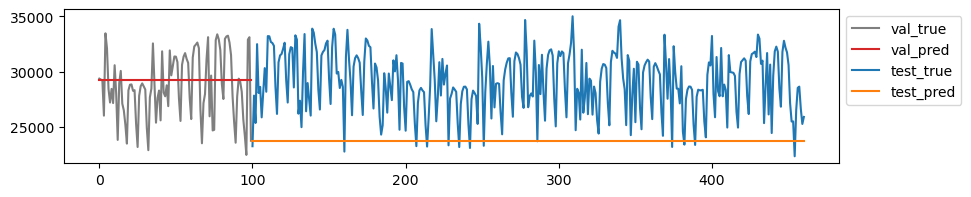

In [14]:
#  naive method

y_pred_valid = np.repeat(train_df.iloc[-1,-1],len(valid_df))
y_true_valid = valid_df['total load actual'].values

y_pred_test = np.repeat(valid_df.iloc[-1,-1],len(test_df))
y_true_test = test_df['total load actual'].values

print(f'valid | MAE: {round(mae(y_true_valid, y_pred_valid),2)}, RMSE: {round(rmse(y_true_valid, y_pred_valid),2)}, MAPE: {round(mape(y_true_valid, y_pred_valid),2)}')
print(f'test  | MAE: {round(mae(y_true_test, y_pred_test),2)}, RMSE: {round(rmse(y_true_test, y_pred_test),2)}, MAPE: {round(mape(y_true_test, y_pred_test),2)}')

plt.figure(figsize=(10,2))
# plot valid data and pred
valid_range = np.arange(0,len(valid_df))
plt.plot(valid_range,y_true_valid, label='val_true', color='C7')
plt.plot(valid_range,y_pred_valid, label='val_pred', color='C3')
# plot test data and pred
test_range = np.arange(valid_range[-1]+1,len(test_df)+valid_range[-1]+1)
plt.plot(test_range,y_true_test, label='test_true')
plt.plot(test_range,y_pred_test, label='test_pred')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

valid | MAE: 2349.87, RMSE: 2890.57, MAPE: 0.08
test  | MAE: 2280.42, RMSE: 2744.94, MAPE: 0.08


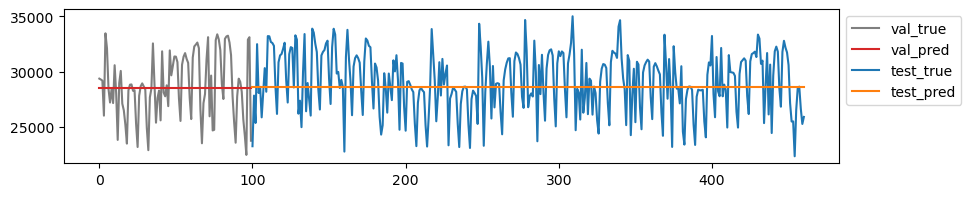

In [15]:
#  mean method

y_pred_valid = np.repeat(np.mean(train_df['total load actual']),len(valid_df))
y_true_valid = valid_df['total load actual'].values

y_pred_test = np.repeat(np.mean(pd.concat([train_df, valid_df])['total load actual']),len(test_df))
y_true_test = test_df['total load actual'].values

print(f'valid | MAE: {round(mae(y_true_valid, y_pred_valid),2)}, RMSE: {round(rmse(y_true_valid, y_pred_valid),2)}, MAPE: {round(mape(y_true_valid, y_pred_valid),2)}')
print(f'test  | MAE: {round(mae(y_true_test, y_pred_test),2)}, RMSE: {round(rmse(y_true_test, y_pred_test),2)}, MAPE: {round(mape(y_true_test, y_pred_test),2)}')

plt.figure(figsize=(10,2))
# plot valid data and pred
valid_range = np.arange(0,len(valid_df))
plt.plot(valid_range,y_true_valid, label='val_true', color='C7')
plt.plot(valid_range,y_pred_valid, label='val_pred', color='C3')
# plot test data and pred
test_range = np.arange(valid_range[-1]+1,len(test_df)+valid_range[-1]+1)
plt.plot(test_range,y_true_test, label='test_true')
plt.plot(test_range,y_pred_test, label='test_pred')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

valid | MAE: 3225.9, RMSE: 3957.62, MAPE: 0.12
test  | MAE: 3272.12, RMSE: 3995.8, MAPE: 0.11


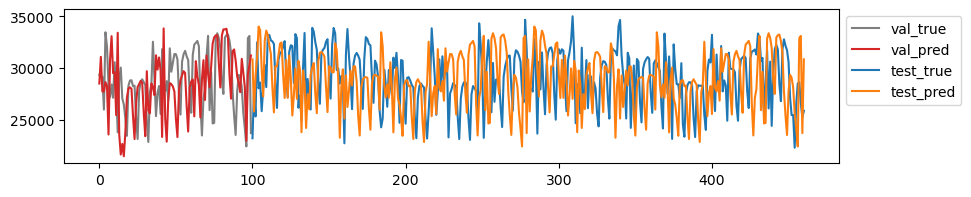

In [16]:
# seasonal naive method

period = 180 # seasonal period in days

def aux(x, df):
    while x not in df.index:
        x -= period
    return df.iloc[x,-1]


y_pred_valid = valid_df.reset_index()['index'].apply(lambda x, df: aux(x, df), args=(train_df,)).values
y_true_valid = valid_df['total load actual'].values

y_pred_test = test_df.reset_index()['index'].apply(lambda x, df: aux(x, df), args=(pd.concat([train_df, valid_df]),)).values
y_true_test = test_df['total load actual'].values

print(f'valid | MAE: {round(mae(y_true_valid, y_pred_valid),2)}, RMSE: {round(rmse(y_true_valid, y_pred_valid),2)}, MAPE: {round(mape(y_true_valid, y_pred_valid),2)}')
print(f'test  | MAE: {round(mae(y_true_test, y_pred_test),2)}, RMSE: {round(rmse(y_true_test, y_pred_test),2)}, MAPE: {round(mape(y_true_test, y_pred_test),2)}')

plt.figure(figsize=(10,2))
# plot valid data and pred
valid_range = np.arange(0,len(valid_df))
plt.plot(valid_range,y_true_valid, label='val_true', color='C7')
plt.plot(valid_range,y_pred_valid, label='val_pred', color='C3')
# plot test data and pred
test_range = np.arange(valid_range[-1]+1,len(test_df)+valid_range[-1]+1)
plt.plot(test_range,y_true_test, label='test_true')
plt.plot(test_range,y_pred_test, label='test_pred')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

valid | MAE: 2322.6, RMSE: 3184.39, MAPE: 0.08
test  | MAE: 2353.82, RMSE: 3097.46, MAPE: 0.08


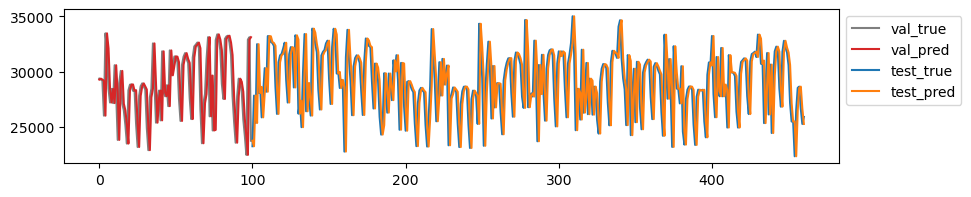

In [17]:
# naive method 1-step forecast

y_pred_valid = valid_df['total load actual'].shift(1).values
y_pred_valid[0] = train_df['total load actual'].iloc[-1]

y_true_valid = valid_df['total load actual'].values

y_pred_test = test_df['total load actual'].shift(1).values
y_pred_test[0] = valid_df['total load actual'].iloc[-1]

y_true_test = test_df['total load actual'].values

print(f'valid | MAE: {round(mae(y_true_valid, y_pred_valid),2)}, RMSE: {round(rmse(y_true_valid, y_pred_valid),2)}, MAPE: {round(mape(y_true_valid, y_pred_valid),2)}')
print(f'test  | MAE: {round(mae(y_true_test, y_pred_test),2)}, RMSE: {round(rmse(y_true_test, y_pred_test),2)}, MAPE: {round(mape(y_true_test, y_pred_test),2)}')

plt.figure(figsize=(10,2))
# plot valid data and pred
valid_range = np.arange(0,len(valid_df))
plt.plot(valid_range,y_true_valid, label='val_true', color='C7')
plt.plot(valid_range,y_pred_valid, label='val_pred', color='C3')
# plot test data and pred
test_range = np.arange(valid_range[-1]+1,len(test_df)+valid_range[-1]+1)
plt.plot(test_range,y_true_test, label='test_true')
plt.plot(test_range,y_pred_test, label='test_pred')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

## xgboost

In [121]:
energy_df = pd.read_csv('data/electric_demand/energy_dataset.csv')
weather_df = pd.read_csv('data/electric_demand/weather_features.csv')

In [122]:
energy_df = energy_df[['time', 'generation solar', 'price actual', 'total load actual']]
temp_s = pd.to_datetime(energy_df['time'])
temp_s = temp_s.apply(lambda x: x.strftime('%Y-%m-%d'))
energy_df['time'] = temp_s

energy_df = energy_df.groupby('time').agg('mean').reset_index()

weather_df.rename(columns={'dt_iso':'time'}, inplace=True)
weather_df = weather_df[['time', 'temp']]

temp_s = pd.to_datetime(weather_df['time'])
temp_s = temp_s.apply(lambda x: x.strftime('%Y-%m-%d'))
weather_df['time'] = temp_s

weather_df = weather_df.groupby('time').agg('mean').reset_index()

df = energy_df.merge(weather_df)

In [123]:
train_df = df.iloc[:1000]
valid_df = df.iloc[1000:1100]
test_df = df.iloc[1100:]

In [124]:
# predict: total load actual (t)
# features: total load (t-1), price actual (t-1), generation solar (t-1), average temp (t-1)
# additional features: total load last week (t-1,...,t-7), is_holiday (t), is_weekend (t)

def extract_features(df):
    df[['generation solar','temp','price actual','last total load actual']] = df[['generation solar','temp','price actual','total load actual']].shift(1)
    df = df.iloc[1:]
    X = df[['generation solar','price actual', 'temp', 'last total load actual']].reset_index(drop=True)
    y = df['total load actual'].reset_index(drop=True)

    return X, y

In [125]:
train_X, train_y = extract_features(train_df)
valid_X, valid_y = extract_features(valid_df)
test_X, test_y = extract_features(test_df)

In [126]:
model = lgb.LGBMRegressor()
model.fit(train_X, train_y)

LGBMRegressor()

valid | MAE: 2231.1, RMSE: 2884.93, MAPE: 0.08
test  | MAE: 2180.31, RMSE: 2674.26, MAPE: 0.08


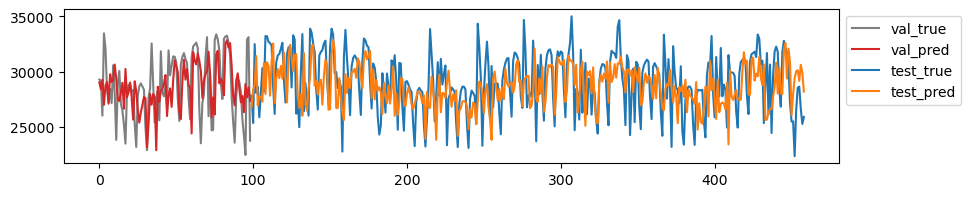

In [127]:
y_pred_valid = model.predict(valid_X)
y_true_valid = valid_y

y_pred_test = model.predict(test_X)
y_true_test = test_y

print(f'valid | MAE: {round(mae(y_true_valid, y_pred_valid),2)}, RMSE: {round(rmse(y_true_valid, y_pred_valid),2)}, MAPE: {round(mape(y_true_valid, y_pred_valid),2)}')
print(f'test  | MAE: {round(mae(y_true_test, y_pred_test),2)}, RMSE: {round(rmse(y_true_test, y_pred_test),2)}, MAPE: {round(mape(y_true_test, y_pred_test),2)}')

plt.figure(figsize=(10,2))
# plot valid data and pred
valid_range = np.arange(0,len(valid_y))
plt.plot(valid_range,y_true_valid, label='val_true', color='C7')
plt.plot(valid_range,y_pred_valid, label='val_pred', color='C3')
# plot test data and pred
test_range = np.arange(valid_range[-1]+1,len(test_y)+valid_range[-1]+1)
plt.plot(test_range,y_true_test, label='test_true')
plt.plot(test_range,y_pred_test, label='test_pred')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

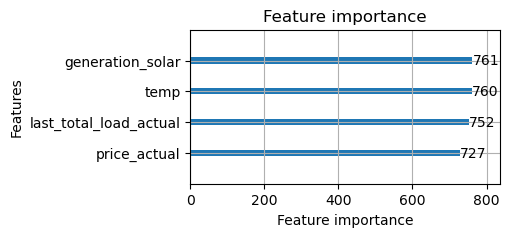

In [128]:
lgb.plot_importance(model, figsize=(4,2))

In [129]:
from sklearn.model_selection import ParameterGrid

param_grid = {'boosting_type':['gbdt','dart'],
              'learning_rate':[0.01, 0.1, 0.5],
              'n_estimators':[20, 40, 100]
              }
              

for temp_config in list(ParameterGrid(param_grid)):
    model = lgb.LGBMRegressor(**temp_config)
    model.fit(train_X, train_y)

    y_pred_valid = model.predict(valid_X)
    y_true_valid = valid_y
    print(temp_config)
    print(f'MAE: {round(mae(y_true_valid, y_pred_valid),2)}, RMSE: {round(rmse(y_true_valid, y_pred_valid),2)}, MAPE: {round(mape(y_true_valid, y_pred_valid),2)}')
    print('--')

{'boosting_type': 'gbdt', 'learning_rate': 0.01, 'n_estimators': 20}
MAE: 2252.51, RMSE: 2761.79, MAPE: 0.08
--
{'boosting_type': 'gbdt', 'learning_rate': 0.01, 'n_estimators': 40}
MAE: 2188.3, RMSE: 2683.12, MAPE: 0.08
--
{'boosting_type': 'gbdt', 'learning_rate': 0.01, 'n_estimators': 100}
MAE: 2130.7, RMSE: 2621.71, MAPE: 0.08
--
{'boosting_type': 'gbdt', 'learning_rate': 0.1, 'n_estimators': 20}
MAE: 2097.51, RMSE: 2653.77, MAPE: 0.08
--
{'boosting_type': 'gbdt', 'learning_rate': 0.1, 'n_estimators': 40}
MAE: 2151.73, RMSE: 2751.52, MAPE: 0.08
--
{'boosting_type': 'gbdt', 'learning_rate': 0.1, 'n_estimators': 100}
MAE: 2231.1, RMSE: 2884.93, MAPE: 0.08
--
{'boosting_type': 'gbdt', 'learning_rate': 0.5, 'n_estimators': 20}
MAE: 2329.09, RMSE: 3016.08, MAPE: 0.08
--
{'boosting_type': 'gbdt', 'learning_rate': 0.5, 'n_estimators': 40}
MAE: 2360.17, RMSE: 3118.06, MAPE: 0.08
--
{'boosting_type': 'gbdt', 'learning_rate': 0.5, 'n_estimators': 100}
MAE: 2353.7, RMSE: 3098.99, MAPE: 0.08
--

test  | MAE: 1998.55, RMSE: 2419.74, MAPE: 0.07


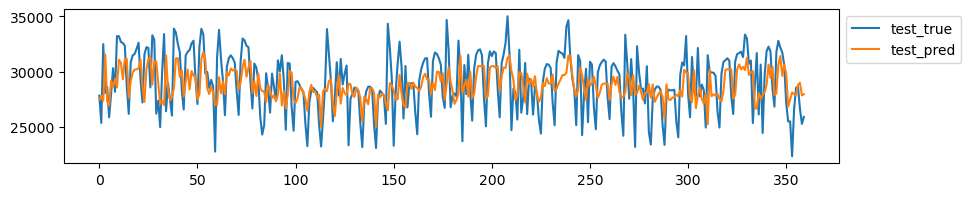

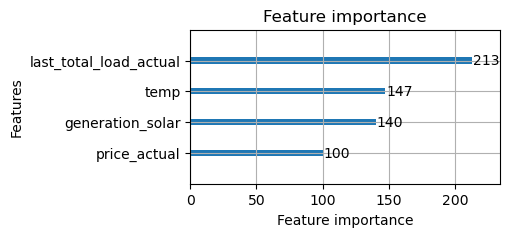

In [130]:
best_hyper = {'boosting_type': 'dart', 'learning_rate': 0.1, 'n_estimators': 20}
model = lgb.LGBMRegressor(**best_hyper)
model.fit(pd.concat([train_X,valid_X]), pd.concat([train_y,valid_y]))

y_pred_test = model.predict(test_X)
y_true_test = test_y
print(f'test  | MAE: {round(mae(y_true_test, y_pred_test),2)}, RMSE: {round(rmse(y_true_test, y_pred_test),2)}, MAPE: {round(mape(y_true_test, y_pred_test),2)}')
plt.figure(figsize=(10,2))
# plot test data and pred
test_range = np.arange(0,len(test_y))
plt.plot(test_range,y_true_test, label='test_true')
plt.plot(test_range,y_pred_test, label='test_pred')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()
lgb.plot_importance(model, figsize=(4,2))
plt.show()

In [131]:
# residual diagnostic
y_pred_train = model.predict(train_X)
residuals = train_y - y_pred_train

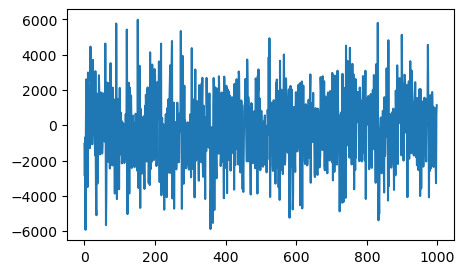

In [132]:
plt.figure(figsize=(5,3))
plt.plot(residuals)
plt.show()

<AxesSubplot:>

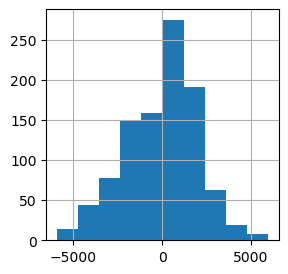

In [133]:
pd.Series(residuals).hist(figsize=(3,3))

## exponential smoothing

In [22]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
from statsmodels.tsa.api import ExponentialSmoothing

from sklearn.model_selection import ParameterGrid

param_grid = {'trend':['add','mul', None],
              'damped_trend':[False, True],
              'seasonal':['add','mul',None]
              }
              

for temp_config in list(ParameterGrid(param_grid)):
    
    if temp_config['trend'] is None:
        temp_config['damped_trend']=False
    if temp_config['seasonal'] is not None:
        temp_config['seasonal_periods']=180

    es = ExponentialSmoothing(endog=train_df['total load actual'], **temp_config)
    es_results = es.fit()


    y_pred_valid = es_results.forecast(len(valid_df))
    y_true_valid = valid_df['total load actual']
    print(temp_config)
    print(f'MAE: {round(mae(y_true_valid, y_pred_valid),2)}, RMSE: {round(rmse(y_true_valid, y_pred_valid),2)},'
          f'MAPE: {round(mape(y_true_valid, y_pred_valid),2)}, AIC: {round(es_results.aic,2)},'
          f'AICC: {round(es_results.aicc,2)}, BIC: {round(es_results.bic,2)},')
    
    print('--')

{'damped_trend': False, 'seasonal': 'add', 'trend': 'add', 'seasonal_periods': 180}
MAE: 2645.04, RMSE: 3234.36,MAPE: 0.09, AIC: 16061.14,AICC: 16146.7, BIC: 16964.17,
--
{'damped_trend': False, 'seasonal': 'add', 'trend': 'mul', 'seasonal_periods': 180}
MAE: 2644.3, RMSE: 3234.6,MAPE: 0.09, AIC: 16061.46,AICC: 16147.02, BIC: 16964.49,
--
{'damped_trend': False, 'seasonal': 'add', 'trend': None, 'seasonal_periods': 180}
MAE: 2655.87, RMSE: 3239.55,MAPE: 0.09, AIC: 16042.38,AICC: 16125.91, BIC: 16935.59,
--
{'damped_trend': False, 'seasonal': 'mul', 'trend': 'add', 'seasonal_periods': 180}
MAE: 2646.2, RMSE: 3245.1,MAPE: 0.09, AIC: 16064.32,AICC: 16149.88, BIC: 16967.34,
--
{'damped_trend': False, 'seasonal': 'mul', 'trend': 'mul', 'seasonal_periods': 180}
MAE: 2645.55, RMSE: 3245.75,MAPE: 0.09, AIC: 16064.66,AICC: 16150.23, BIC: 16967.69,
--
{'damped_trend': False, 'seasonal': 'mul', 'trend': None, 'seasonal_periods': 180}
MAE: 2656.52, RMSE: 3241.85,MAPE: 0.09, AIC: 16042.31,AICC: 161

test  | MAE: 2428.08, RMSE: 2929.93, MAPE: 0.09


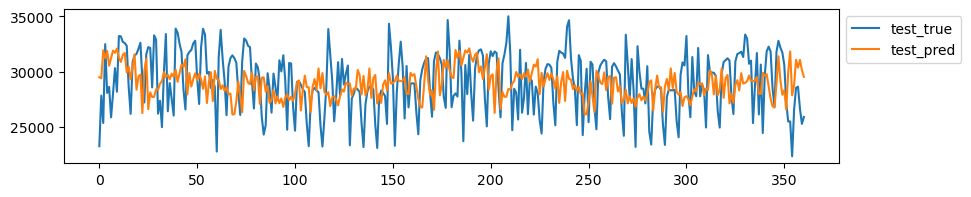

In [119]:
# es
es = ExponentialSmoothing(endog=pd.concat([train_df,valid_df])['total load actual'], trend='add', seasonal='add', damped_trend=True, seasonal_periods=180)

es_results = es.fit()

y_pred_test = es_results.forecast(len(test_df))
y_true_test = test_df['total load actual'].values

print(f'test  | MAE: {round(mae(y_true_test, y_pred_test),2)}, RMSE: {round(rmse(y_true_test, y_pred_test),2)}, MAPE: {round(mape(y_true_test, y_pred_test),2)}')

plt.figure(figsize=(10,2))
# plot test data and pred
test_range = np.arange(0,len(test_df))
plt.plot(test_range,y_true_test, label='test_true')
plt.plot(test_range,y_pred_test, label='test_pred')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

## arima

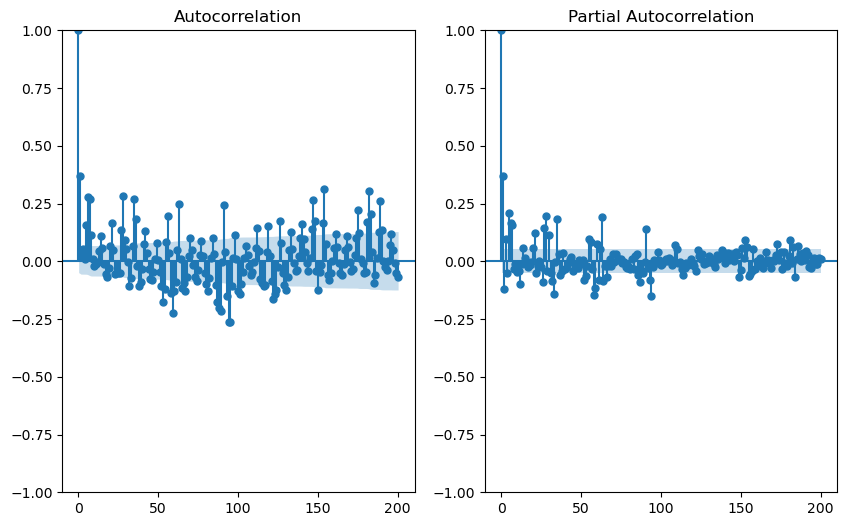

In [154]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
sm.graphics.tsaplots.plot_acf(temp_df['total load actual'].values, lags=200, ax=axes[0])
sm.graphics.tsaplots.plot_pacf(temp_df['total load actual'].values, lags=200, ax=axes[1])
plt.show()

In [139]:
from statsmodels.tsa.arima.model import ARIMA

param_grid = {'order':[(2,1,2),(1,1,2),(3,1,2),(2,1,3),(2,1,1)], #(p,d,q)
              'seasonal_order':[(0,0,0,0)] #(P,D,Q,S)
              }
              
for temp_config in list(ParameterGrid(param_grid)):

    arima = ARIMA(endog=train_df['total load actual'], **temp_config)
    arima_results = arima.fit()

    y_pred_valid = arima_results.forecast(len(valid_df))
    y_true_valid = valid_df['total load actual']
    print(temp_config)
    print(f'MAE: {round(mae(y_true_valid, y_pred_valid),2)}, RMSE: {round(rmse(y_true_valid, y_pred_valid),2)},'
          f'MAPE: {round(mape(y_true_valid, y_pred_valid),2)}, AIC: {round(arima_results.aic,2)},'
          f'AICC: {round(arima_results.aicc,2)}, BIC: {round(arima_results.bic,2)},')
    
    print('--')

{'order': (2, 1, 2), 'seasonal_order': (0, 0, 0, 0)}
MAE: 2387.66, RMSE: 2944.48,MAPE: 0.08, AIC: 18528.35,AICC: 18528.41, BIC: 18552.88,
--
{'order': (1, 1, 2), 'seasonal_order': (0, 0, 0, 0)}
MAE: 2409.84, RMSE: 2967.64,MAPE: 0.08, AIC: 18526.84,AICC: 18526.88, BIC: 18546.47,
--
{'order': (3, 1, 2), 'seasonal_order': (0, 0, 0, 0)}
MAE: 2416.05, RMSE: 2974.64,MAPE: 0.08, AIC: 18529.25,AICC: 18529.33, BIC: 18558.69,
--
{'order': (2, 1, 3), 'seasonal_order': (0, 0, 0, 0)}
MAE: 2391.91, RMSE: 2949.14,MAPE: 0.08, AIC: 18528.04,AICC: 18528.12, BIC: 18557.48,
--
{'order': (2, 1, 1), 'seasonal_order': (0, 0, 0, 0)}
MAE: 2448.35, RMSE: 3009.74,MAPE: 0.08, AIC: 18538.02,AICC: 18538.06, BIC: 18557.65,
--


test  | MAE: 2342.96, RMSE: 2818.75, MAPE: 0.08


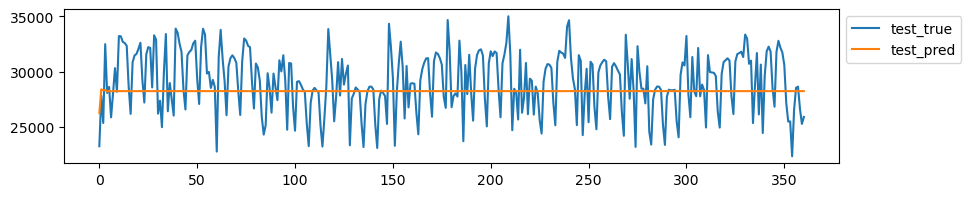

In [168]:
arima = ARIMA(endog=pd.concat([train_df,valid_df])['total load actual'], order = (3,1,2))

arima_results = arima.fit()

y_pred_test = arima_results.forecast(len(test_df))
y_true_test = test_df['total load actual'].values

print(f'test  | MAE: {round(mae(y_true_test, y_pred_test),2)}, RMSE: {round(rmse(y_true_test, y_pred_test),2)}, MAPE: {round(mape(y_true_test, y_pred_test),2)}')

plt.figure(figsize=(10,2))
# plot test data and pred
test_range = np.arange(0,len(test_df))
plt.plot(test_range,y_true_test, label='test_true')
plt.plot(test_range,y_pred_test, label='test_pred')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In [104]:
# prophet
from prophet import Prophet

df = pd.read_csv('data/electric_demand/energy_dataset.csv')
df = df[['time','total load actual']]

temp_s = pd.to_datetime(df['time'])
temp_s = temp_s.apply(lambda x: x.strftime('%Y-%m-%d'))
df['time'] = temp_s

temp_df = df.groupby('time').agg('mean').reset_index()

temp_df.rename(columns={'time':'ds','total load actual':'y'}, inplace=True)

train_df = temp_df.iloc[:1000]
valid_df = temp_df.iloc[1000:1100]
test_df = temp_df.iloc[1100:]

In [118]:
model = Prophet(growth='linear')
model.add_country_holidays(country_name='ES')

#train_df['cap']=32500
model.fit(train_df)

future = model.make_future_dataframe(periods=len(valid_df))
#future['cap']=32500

19:01:49 - cmdstanpy - INFO - Chain [1] start processing
19:01:49 - cmdstanpy - INFO - Chain [1] done processing


valid | MAE: 1762.44, RMSE: 2332.72, MAPE: 0.06


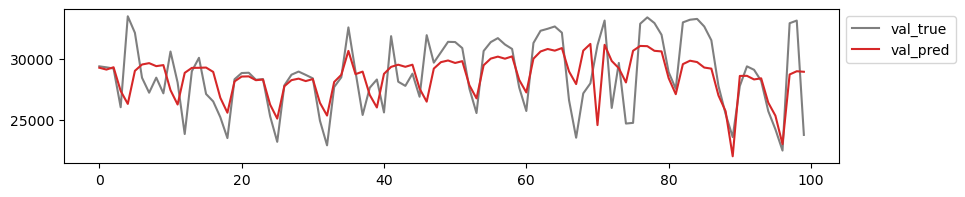

In [119]:
forecast = model.predict(future)

y_pred_valid = forecast['yhat'].iloc[-len(valid_df):]
y_true_valid = valid_df['y']

print(f'valid | MAE: {round(mae(y_true_valid, y_pred_valid),2)}, RMSE: {round(rmse(y_true_valid, y_pred_valid),2)}, MAPE: {round(mape(y_true_valid, y_pred_valid),2)}')

plt.figure(figsize=(10,2))
# plot valid data and pred
valid_range = np.arange(0,len(y_true_valid))
plt.plot(valid_range,y_true_valid, label='val_true', color='C7')
plt.plot(valid_range,y_pred_valid, label='val_pred', color='C3')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

22:13:53 - cmdstanpy - INFO - Chain [1] start processing
22:13:53 - cmdstanpy - INFO - Chain [1] done processing


test  | MAE: 1644.28, RMSE: 2204.18, MAPE: 0.06


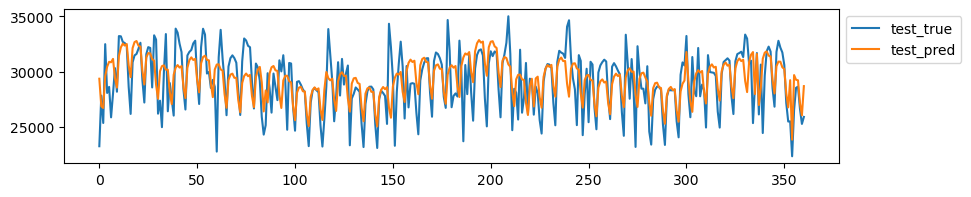

In [120]:
model = Prophet(growth='linear')
model.add_country_holidays(country_name='ES')

model.fit(pd.concat([train_df,valid_df]))

future = model.make_future_dataframe(periods=len(test_df))

forecast = model.predict(future)

y_pred_test = forecast['yhat'].iloc[-len(test_df):]
y_true_test = test_df['y']

print(f'test  | MAE: {round(mae(y_true_test, y_pred_test),2)}, RMSE: {round(rmse(y_true_test, y_pred_test),2)}, MAPE: {round(mape(y_true_test, y_pred_test),2)}')

plt.figure(figsize=(10,2))
# plot test data and pred
test_range = np.arange(0,len(test_df))
plt.plot(test_range,y_true_test, label='test_true')
plt.plot(test_range,y_pred_test, label='test_pred')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

## TCN

In [ ]:
# dataset prep
df = pd.read_csv('data/electric_demand/energy_dataset.csv')
df = df[['time','total load actual']]

temp_s = pd.to_datetime(df['time'])
temp_s = temp_s.apply(lambda x: x.strftime('%Y-%m-%d'))
df['time'] = temp_s

temp_df = df.groupby('time').agg('mean').reset_index()

train_df = temp_df.iloc[:1000]
valid_df = temp_df.iloc[1000:1100]
test_df = temp_df.iloc[1100:]

In [134]:
import tensorflow as tf


class TCN(tf.Module):

    def __init__(self):
        super(TCN, self).__init__()
    
    def call():
        return